In [1]:
import sys
import os

src_dir = os.path.dirname(os.getcwd())

if src_dir not in sys.path:
    sys.path.append(src_dir)
    
import matplotlib.pyplot as plt
# noinspection PyUnresolvedReferences
from utils import (
    ddpm_schedules, 
    CNN, 
    DDPM, 
    load_pickle, 
    CNNClassifier, 
    save_pickle, 
    calc_loss_per_epoch, 
    load_model,
    get_feature_vector,
    calculate_fid,
    generate_samples,
    save_images,
    FashionMNISTDM,
    generate_image_decoding
)
from plotting_utils import format_axes
import numpy as np
import torch
from torchvision import transforms
from torchvision.datasets import MNIST, FashionMNIST
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm import tqdm

device = 'mps' if torch.backends.mps.is_available() else 'cpu'

In [2]:
mnist_train_dataset = MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
mnist_test_dataset = MNIST('../data', train=True, download=True, transform=transforms.ToTensor())

mnist_train_dataloader = DataLoader(mnist_train_dataset, batch_size=128, shuffle=False, num_workers=4, drop_last=True)
mnist_test_dataloader = DataLoader(mnist_test_dataset, batch_size=128, shuffle=False, num_workers=4, drop_last=True)

fashion_mnist_train_dataset = FashionMNIST('../data', train=True, download=True, transform=transforms.ToTensor())
fashion_mnist_test_dataset = FashionMNIST('../data', train=False, download=True, transform=transforms.ToTensor())

fashion_mnist_train_dataloader = DataLoader(fashion_mnist_train_dataset, batch_size=128, shuffle=False, num_workers=4, drop_last=True)
fashion_mnist_test_dataloader = DataLoader(fashion_mnist_test_dataset, batch_size=128, shuffle=False, num_workers=4, drop_last=True)

# Table of Contents
- [Figure 10: Illustration showing how the MNIST digits get encoded](#fig-10)
- [Figure 11: Training loss of the Fashion MNIST model](#fig-11)
- [Figure 12: Frechet MNIST Distance (FMD) for the Fashion MNIST model](#fig-12)
- [Figure 13: Illustration showing how the Fashion MNIST digits get decoded](#fig-13)
- [Figure 14: Samples generated by the Fashion MNIST model](#fig-14)

# <a id="fig-10"></a>Figure 10: Illustration showing how the MNIST digits get encoded
Outputs: q2b_encoding.png

In [22]:
model = load_model('mnist', 99)

mnist_batch, _ = next(iter(mnist_train_dataloader))
fashion_mnist_batch, _ = next(iter(fashion_mnist_train_dataloader))

x = mnist_batch[0].unsqueeze(0).repeat(11, 1, 1, 1)
t = torch.arange(0, 1001, 100)
eps = fashion_mnist_batch[0].unsqueeze(0).repeat(11, 1, 1, 1)

encodings = model.encode(x, t, eps)

save_images(encodings, 11, f'{src_dir}/../report/figures/q2_encoding.png')

# <a id="fig-11">Figure 11: Training loss of the Fashion MNIST model
q2b_losses.png

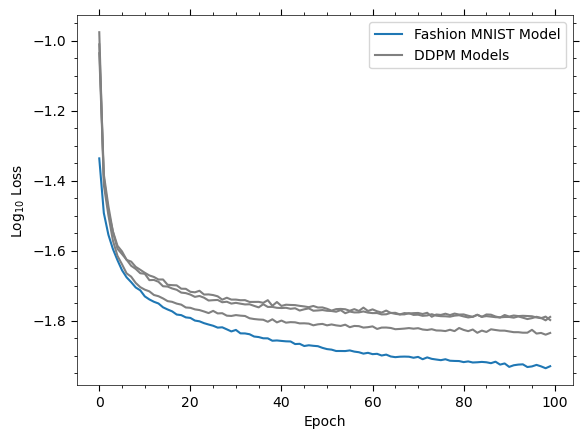

In [36]:
fig, ax = plt.subplots()

losses_fmnist = load_pickle('../outputs/fashion_mnist/losses_epoch.pkl')

losses_def = load_pickle('../outputs/ddpm/default_model/losses_epoch.pkl')
losses_short = load_pickle('../outputs/ddpm/short_model/losses_epoch.pkl')
losses_long = load_pickle('../outputs/ddpm/long_model/losses_epoch.pkl')

plt.plot(np.log10(losses_fmnist), label='Fashion MNIST Model')
plt.plot(np.log10(losses_def), c='grey', label='DDPM Models')
plt.plot(np.log10(losses_short), c='grey')
plt.plot(np.log10(losses_long), c='grey')

plt.ylabel(r'Log$_{10}$ Loss')
plt.xlabel(r'Epoch')
plt.legend()
format_axes(ax)

# plt.savefig(f'{src_dir}/../report/figures/q2_training_loss.png', bbox_inches='tight')

# <a id="fig-12">Figure 12: Frechet MNIST Distance (FMD) for the Fashion MNIST model
q2b_fmd.png

In [4]:
mnist_classifier = load_model('mnist_classifier', 20)
mnist_classifier.final = nn.Identity()
mnist_classifier

CNNClassifier(
  (blocks): ModuleList(
    (0): CNNBlock(
      (net): Sequential(
        (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): LayerNorm((32, 28, 28), eps=1e-05, elementwise_affine=True)
        (2): GELU(approximate='none')
      )
    )
    (1): CNNBlock(
      (net): Sequential(
        (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): LayerNorm((64, 28, 28), eps=1e-05, elementwise_affine=True)
        (2): GELU(approximate='none')
      )
    )
    (2): CNNBlock(
      (net): Sequential(
        (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): LayerNorm((128, 28, 28), eps=1e-05, elementwise_affine=True)
        (2): GELU(approximate='none')
      )
    )
    (3): CNNBlock(
      (net): Sequential(
        (0): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): LayerNorm((64, 28, 28), eps=1e-05, elementwise_affine=True)
        (2): GELU(a

In [5]:
temp_dataloader = DataLoader(mnist_test_dataset, batch_size=512, num_workers=4, drop_last=True)
real_mnist = next(iter(temp_dataloader))[0]
real_features = get_feature_vector(mnist_classifier, real_mnist)

epoch_range = list(range(0, 30, 5)) + list(range(30, 100, 10)) + [99]
samples_fmnist = generate_samples('fashion_mnist', epoch_range, 32, device)

feature_vectors_fmnist = torch.empty(samples_fmnist.shape[0], 32, 1024)
fids_fmnist = torch.empty(samples_fmnist.shape[0])

for i in tqdm(range(samples_fmnist.shape[0])):
    feature_vectors_fmnist[i] = get_feature_vector(mnist_classifier, samples_fmnist[i])
    
for i in tqdm(range(samples_fmnist.shape[0])):
    fids_fmnist[i] = calculate_fid(real_features, feature_vectors_fmnist[i])
    
fmds_def = load_pickle('./fmds_def.pkl')
fmds_short = load_pickle('./fmds_short.pkl')
fmds_long = load_pickle('./fmds_long.pkl')
fmds_mnist = load_pickle('./fmds_mnist.pkl')

100%|██████████| 14/14 [00:18<00:00,  1.34s/it]


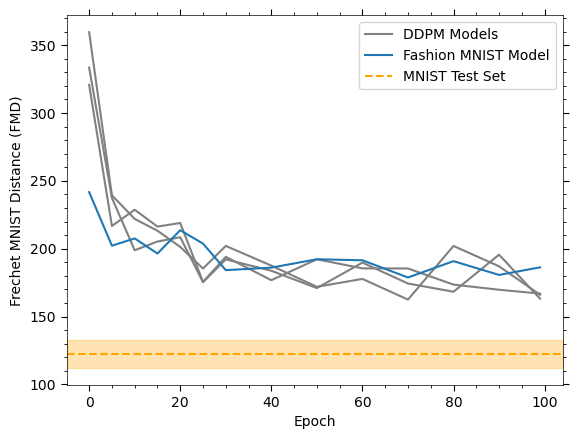

In [7]:
fig, ax = plt.subplots()
plt.plot(epoch_range, fmds_def, label='DDPM Models', color='grey')
plt.plot(epoch_range, fmds_short, color='grey')
plt.plot(epoch_range, fmds_long, color='grey')
plt.plot(epoch_range, fids_fmnist, label='Fashion MNIST Model')

plt.ylabel(r'Frechet MNIST Distance (FMD)')
plt.xlabel(r'Epoch')

mean, std = fmds_mnist.mean(), fmds_mnist.std()
xlims = plt.xlim()
plt.axhline(y=mean, color='orange', linestyle='--', label='MNIST Test Set')
plt.fill_between(np.linspace(xlims[0], xlims[1]), mean - std, mean + std, color='orange', alpha=0.3)
plt.xlim(xlims)

plt.legend()
format_axes(ax)
# plt.savefig(f'{src_dir}/../report/figures/q2_fmd.png', bbox_inches='tight')

# <a id="fig-13">Figure 13: Illustration showing how the Fashion MNIST digits get decoded
q2b_decoding.png

In [13]:
model = load_model('fashion_mnist', 99)
model.set_sample_size(2)
fminst_model_decoding = generate_image_decoding(model, 2, range(900, 0, -100), device)
save_images(fminst_model_decoding.view(22, 1, 28, 28), 11, f'{src_dir}/../report/figures/q2_decoding.png')

# <a id="fig-14">Figure 14: Samples generated by the Fashion MNIST model
q2b_samples_final.png

In [14]:
samples_final = generate_samples('fashion_mnist', [99], 32, device)

100%|██████████| 1/1 [00:13<00:00, 13.48s/it]


In [24]:
save_images(samples_final.view(32, 1, 28, 28), 8, f'{src_dir}/../report/figures/q2_samples_final.png')